In [1]:
from google.colab import files
uploaded = files.upload()

Saving CC GENERAL.csv to CC GENERAL.csv


In [2]:
#c1: Load the uploaded CSV into a dataframe
import pandas as pd

# Get the uploaded file name (first file)
file_name = list(uploaded.keys())[0]

# Read the CSV into a pandas DataFrame
df = pd.read_csv(file_name)

print("Dataset Loaded Successfully!")
print("Shape:", df.shape)

df.head()


Dataset Loaded Successfully!
Shape: (8950, 18)


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [3]:
# 2: Dr p ID columns (not useful for ML)

# Customer IDs do not help in clustering (they are unique for each user)
id_cols = [col for col in df.columns if 'ID' in col.upper()]

if id_cols:
    print("Dropping ID columns:", id_cols)
    df = df.drop(columns=id_cols)

# 3: Convert all columns to numeric (Invalid values are turned into NaN)

df = df.apply(pd.to_numeric, errors='coerce')

# Check missing values count
df.isna().sum()

Dropping ID columns: ['CUST_ID']


,0
BALANCE,0
BALANCE_FREQUENCY,0
PURCHASES,0
ONEOFF_PURCHASES,0
INSTALLMENTS_PURCHASES,0
CASH_ADVANCE,0
PURCHASES_FREQUENCY,0
ONEOFF_PURCHASES_FREQUENCY,0
PURCHASES_INSTALLMENTS_FREQUENCY,0
CASH_ADVANCE_FREQUENCY,0


In [4]:
# 4: Fill missing values using Median

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

print("Total missing values after imputation:", X.isna().sum().sum())


Total missing values after imputation: 0


In [5]:
# 5: Scale all features
# KMeans relies on distances and scaling improves accuracy

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# 6: Try different values of k (2 to 8)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

K_range = range(2, 9)
inertias = []
sil_scores = []

print("Testing different values of k:")

for k in K_range:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(X_scaled)

    inertias.append(model.inertia_)
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append(sil)

    print(f"k={k} | Inertia={model.inertia_:.0f} | Silhouette={sil:.4f}")

# Select k with the highest silhouette score
best_k = K_range[sil_scores.index(max(sil_scores))]
print("\nBest k found:", best_k)


Testing different values of k:
k=2 | Inertia=128953 | Silhouette=0.2795
k=3 | Inertia=112596 | Silhouette=0.2067
k=4 | Inertia=105340 | Silhouette=0.1665
k=5 | Inertia=92131 | Silhouette=0.1926
k=6 | Inertia=87267 | Silhouette=0.1923
k=7 | Inertia=83154 | Silhouette=0.2153
k=8 | Inertia=76655 | Silhouette=0.2036

Best k found: 2


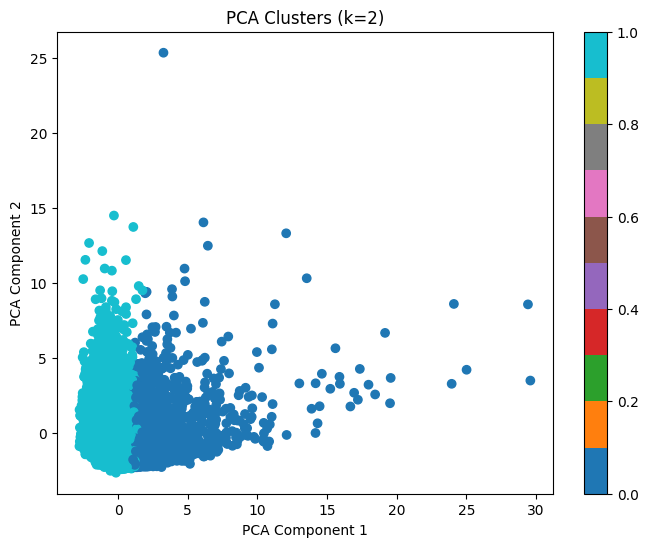

In [7]:
# 7: Fit final KMeans model using best k

kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to dataframe
df['cluster'] = labels

# 8: PCA for visualization (2D)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
plt.title(f"PCA Clusters (k={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.show()

In [10]:
# 9: Cluster Profiles

cluster_profiles = df.groupby('cluster').mean().round(2)

print("\nCluster Sizes:")
print(df['cluster'].value_counts())

print("\nCluster Feature Means:")
cluster_profiles



Cluster Sizes:
cluster
1    7090
0    1860
Name: count, dtype: int64

Cluster Feature Means:


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
cluster,,,,,,,,,,,,,,,,,
0,2147.31,0.98,3364.89,2075.08,1290.14,761.44,0.94,0.59,0.71,0.08,2.23,46.13,7182.54,3595.42,1202.23,0.29,11.89
1,1411.57,0.85,383.64,203.48,180.45,1035.91,0.37,0.10,0.27,0.15,3.52,6.47,3789.15,1244.59,772.38,0.12,11.42


In [17]:
# --- Save Final Outputs ---

import os
import matplotlib.pyplot as plt

out_dir = "/content/segmentation_outputs"
os.makedirs(out_dir, exist_ok=True)

# Save CSV
df.to_csv(os.path.join(out_dir, "customer_segments.csv"), index=False)

# Save PCA plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
plt.title(f"PCA Clusters (k={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar()
plt.savefig(os.path.join(out_dir, "pca_clusters.png"), bbox_inches='tight')
plt.close()

print("Saved customer_segments.csv and pca_clusters.png")

Saved customer_segments.csv and pca_clusters.png
